# Анализ временного ряда трендовых видео на YouTube.

Датасет был взял с kaggle: https://www.kaggle.com/datasnaek/youtube-new?select=CAvideos.csv. Будем использовать информацию только по США.

## Первичный анализ данных.

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
cat_path = 'data/CA_category_id.json'
videos_path = 'data/CAvideos.csv'

Выгрузим данные по трендовым видео.

In [5]:
video_data = pd.read_csv(videos_path, parse_dates=['trending_date'])

In [6]:
video_data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [7]:
video_data.shape

(40881, 16)

Посмотрим на колонки:

In [8]:
video_data.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

Некоторая статистика по таблице:

In [9]:
video_data.describe()

,category_id,views,likes,dislikes,comment_count
count,40881.000000,4.088100e+04,4.088100e+04,4.088100e+04,4.088100e+04
mean,20.795553,1.147036e+06,3.958269e+04,2.009195e+03,5.042975e+03
std,6.775054,3.390913e+06,1.326895e+05,1.900837e+04,2.157902e+04
min,1.000000,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,20.000000,1.439020e+05,2.191000e+03,9.900000e+01,4.170000e+02
50%,24.000000,3.712040e+05,8.780000e+03,3.030000e+02,1.301000e+03
75%,24.000000,9.633020e+05,2.871700e+04,9.500000e+02,3.713000e+03
max,43.000000,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06


Видим, что есть видео, где 0 лайков, дизлайков и комментариев. Очевидно, на данных видео они отключены. Максимальные значения всех полей могут поместиться в int32, так что можно будет уменьшить занимаемую память при необходимости.

Также видим, что на 75% видео, которые находятся в трендах, меньше миллиона просмотров, и на 75% трендовых видео менее 1000 дизлайков. Видно, что в данной выборке лайки ставят чаще, чем дизлайки. Порядок максимальных величин для лайков, дизлайков и комментариев одинаковый.

In [10]:
video_data.describe(include=['object'])

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description
count,40881,40881,40881,40881,40881,40881,40881,39585
unique,24427,205,24573,5076,23613,20157,24422,22345
top,6ZfuNTqbHE8,18.11.06,Drake - God's Plan (Official Audio),SET India,2017-12-20T23:00:00.000Z,[none],https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg,Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...
freq,8,200,15,192,11,2385,8,130


Пока не проводилась предобработка, про эти поля особо ничего сказать нельзя. 

Единственное, что можно отметить: у всех видеозаписей разный channel_title. Это может означать, что либо в тренды попадали видео с разных каналов(без повторений), либо к моменту измерения очередного тренда канал менял название.

Также видно, что разные видео могли попадать в тренды в разные дни(то есть повторяться).

Всего дней, в которых проводился сбор датасета - 205.

In [11]:
video_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to 40880
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40881 non-null  object
 1   trending_date           40881 non-null  object
 2   title                   40881 non-null  object
 3   channel_title           40881 non-null  object
 4   category_id             40881 non-null  int64 
 5   publish_time            40881 non-null  object
 6   tags                    40881 non-null  object
 7   views                   40881 non-null  int64 
 8   likes                   40881 non-null  int64 
 9   dislikes                40881 non-null  int64 
 10  comment_count           40881 non-null  int64 
 11  thumbnail_link          40881 non-null  object
 12  comments_disabled       40881 non-null  bool  
 13  ratings_disabled        40881 non-null  bool  
 14  video_error_or_removed  40881 non-null  bool  
 15  de

Выборка содержит всего 40881 объекта, поэтому особого смысла в понижении размерности типа нет. Оставим так.

Посмотрим на распределение булевых данных.

In [12]:
video_data.describe(include=['bool'])

,comments_disabled,ratings_disabled,video_error_or_removed
count,40881,40881,40881
unique,2,2,2
top,False,False,False
freq,40298,40602,40854


Можно видеть, что в трендовых видео редко отключался рейтинг или комментарии, и очень редко видео оказалось удалено к моменту обкачки. 

Посмотрим на категории повнимательнее:

In [13]:
video_data['category_id'].unique()

array([10, 23, 24, 25, 22, 26,  1, 28, 20, 17, 29, 15, 19,  2, 27, 43, 30])

In [14]:
video_data['category_id'].value_counts(dropna=False)

24    13451
25     4159
22     4105
23     3773
10     3731
17     2787
1      2060
26     2007
20     1344
28     1155
27      991
19      392
15      369
2       353
43      124
29       74
30        6
Name: category_id, dtype: int64

Используется всего 17 категорий, null-ов нет, id категории идут не по порядку. Самая популярная категория - 24я, встречается значительно чаще остальных

И, наконец, посмотрим на пропуски:

In [16]:
video_data.isnull().sum()

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               1296
dtype: int64

Они есть только в описании.

### Цель проекта:

Исследовать взаимосвязь реакции пользователя(просмотры, лайки, дизлайки) на появление видео в трендах youtube и категории с течением времени. Предсказать реакцию пользователя на появление видео определенной категории в будущем. 

## Предобработка

Посмотрим еще раз на данные и посмотрим, что можно удалить.

In [17]:
video_data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


video_id пока оставим - они неуникальны и могут дать полезную информацию. Дату оставляем, заголовок - удалим(если захочется информации о содержании - есть теги или в крайнем случае описание). Название канала - удаляем(уникальные), категорию оставим, время публикации - в рамках нашей задачи не очень полезная информация, удалим. Теги сначала обработаем. thumbnail_link удалим. description - удалим, тк информации много в категории и тегах, а обработка description может выдать непредсказуемые ситуации.

Отсортируем результат по trending_time.

In [64]:
data = video_data.drop(['title', 'channel_title', 'thumbnail_link', 'description', 'publish_time'], axis=1)
data.sort_values(by='trending_date', inplace=True)

In [65]:
import re
def prepare(s):
    res = re.sub(r'"', '', s).split('|')
    res = [r.lower().strip() for r in res]
    return res

In [66]:
from itertools import chain
len(set(chain(*[prepare(s) for s in data['tags']])))

138042

Уникальный тегов очень много, нет смысла их оставлять и как-то напрямую кодировать. Можно было бы подойти с точки зрения векторизации текста и снижения размерности, но для задачи исследования данных это излишне. Поэтому удалим.

In [67]:
data.drop(['tags'], axis=1, inplace=True)

Изменим тип category_id:

In [68]:
data['category_id'] = data['category_id'].astype('category')

In [69]:
data.head()

,video_id,trending_date,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
3398,6ZfuNTqbHE8,17.01.12,24,56367282,2157741,34078,303178,False,False,False
3526,OKJSWaGDMXA,17.01.12,17,450817,14867,116,1116,False,False,False
3527,BO0jkL1oWjg,17.01.12,25,79882,1038,65,377,False,False,False
3528,kehML-RAkd4,17.01.12,24,1538576,81240,678,7586,False,False,False
3529,yZJXUeh-fv0,17.01.12,24,262066,768,229,37,False,False,False


Многие зависимости целесообразно рассматривать отдельно внутри каждой категории видео(в видео про котов лайки зависят от просмотров иначе, чем в видео про политику). Разобьем все видео на группы по категориям.

In [73]:
cats = data['category_id'].unique()

In [74]:
groups = []
for cat in cats:
    groups.append(data[data['category_id'] == cat])
len(groups)

17

## Визуальный анализ

Посмотрим на распределение категорий:

<AxesSubplot:>

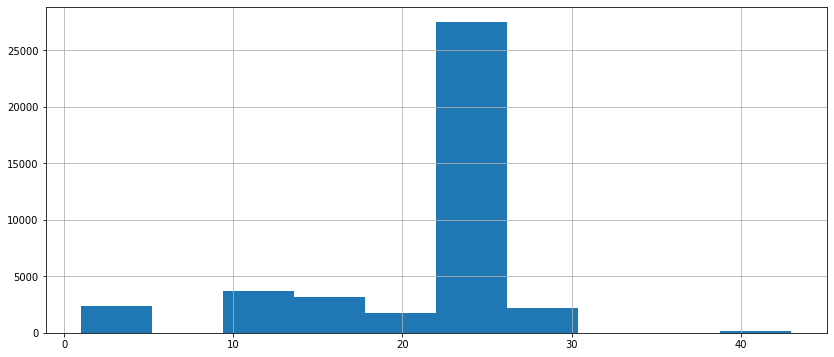

In [70]:
plt.figure(figsize=(14,6))
data['category_id'].hist()

Как можно заметить, категория 24 кардинально отличается по популярности от всех остальных.

Посмотрим для одной категории зависимость лайков, дизлайков и комментариев от числа просмотров.

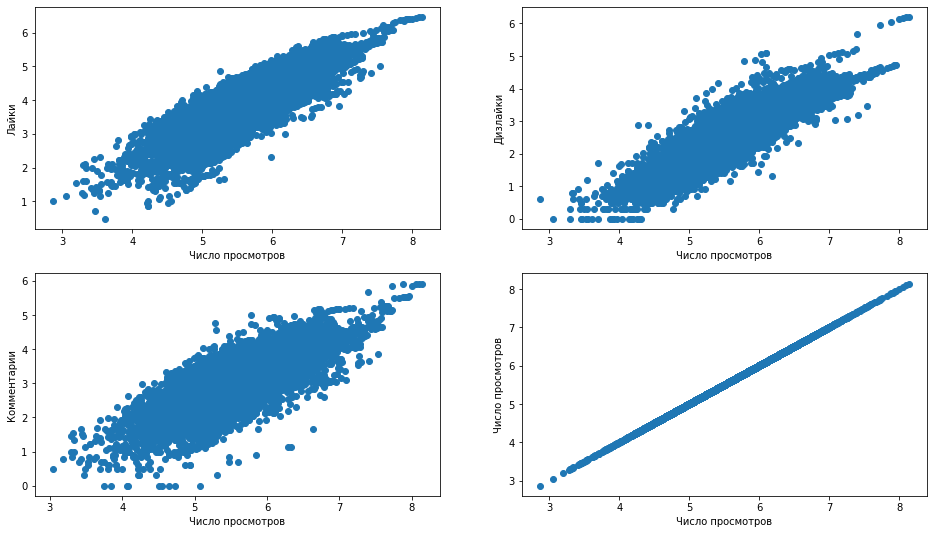

In [93]:
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(223)  
ax4 = fig.add_subplot(224)

ax1.set_xlabel('Число просмотров')
ax1.set_ylabel('Лайки')

ax2.set_xlabel('Число просмотров')
ax2.set_ylabel('Дизлайки')

ax3.set_xlabel('Число просмотров')
ax3.set_ylabel('Комментарии')

ax4.set_xlabel('Число просмотров')
ax4.set_ylabel('Число просмотров')

ax1.scatter(np.log10(groups[0]['views']), np.log10(groups[0]['likes']))
ax2.scatter(np.log10(groups[0]['views']), np.log10(groups[0]['dislikes']))
ax3.scatter(np.log10(groups[0]['views']), np.log10(groups[0]['comment_count']))
ax4.scatter(np.log10(groups[0]['views']), np.log10(groups[0]['views']))

В логарифмической шкале все три зависимости имеют приближенную линейную зависимость: то есть **лайки, дизлайки и комментарии зависят от числа просмотров**.

Тоже самое для произвольной другой группы:

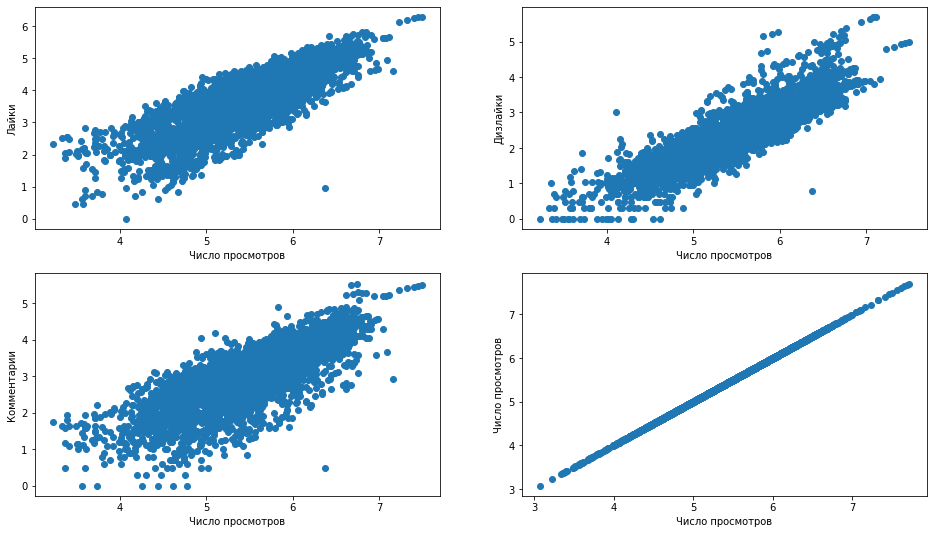

In [96]:
fig = plt.figure(figsize=(16,9))

num = 9

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(223)  
ax4 = fig.add_subplot(224)

ax1.set_xlabel('Число просмотров')
ax1.set_ylabel('Лайки')

ax2.set_xlabel('Число просмотров')
ax2.set_ylabel('Дизлайки')

ax3.set_xlabel('Число просмотров')
ax3.set_ylabel('Комментарии')

ax4.set_xlabel('Число просмотров')
ax4.set_ylabel('Число просмотров')

ax1.scatter(np.log10(groups[num]['views']), np.log10(groups[num]['likes']))
ax2.scatter(np.log10(groups[num]['views']), np.log10(groups[num]['dislikes']))
ax3.scatter(np.log10(groups[num]['views']), np.log10(groups[num]['comment_count']))
ax4.scatter(np.log10(groups[num]['views']), np.log10(groups[num]['views']))

В целом тенденция сохраняется.

Можно заметить, что во всех трех зависимостях для данной группы присутствует один и тот же выброс.

Как обстоят дела с зависимостью лайков и дизлайков от времени? А просмотров?

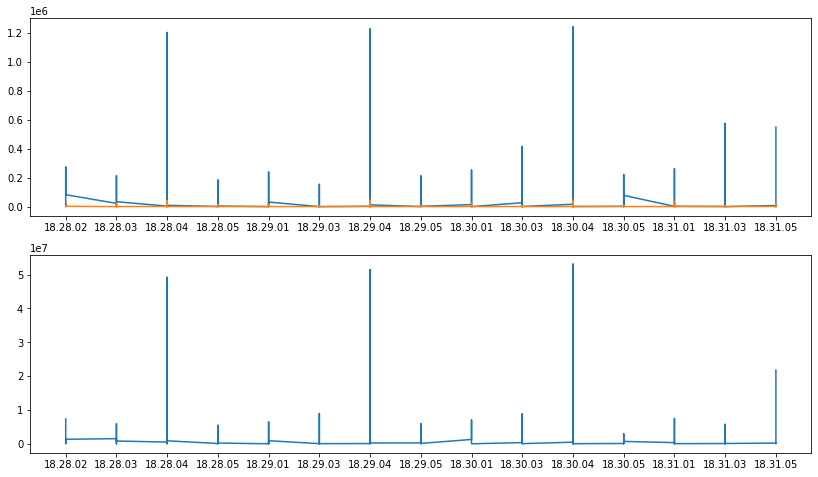

In [118]:
fig = plt.figure(figsize=(14,8))

group = groups[0][-1000:]

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(group['trending_date'], group['likes'])
ax1.plot(group['trending_date'], group['dislikes'])
ax2.plot(group['trending_date'], group['views'])

Особой взаимосвязи не видно, но виден один важный факт: **каждый месяц в числе лайков и просмотров на трендовом видео заметен яркий пик**, причем значение этого пика примерно одинаково внутри своего графика для данной группы.

## Проверка гипотез

Проверим корреляцию (Пирсона) числа лайков и числа просмотров для первой группы. А также для логарифмированных их значений.

In [161]:
x0 = np.log10(np.clip(groups[num]['views'], 1e-7, np.inf))
y0 = np.log10(np.clip(groups[num]['likes'], 1e-7, np.inf))
num = 0
stats.pearsonr(x0, y0)

(0.5398412973410565, 0.0)

Согласно критерию, данные некоррелированы, но с учетом того, что критерий Пирсона плохо реагирует на выбросы, этот вывод неокончательный.

Попробуем также для обычной шкалы:

In [166]:
x0 = groups[num]['views']
y0 = groups[num]['likes']
num = 0
stats.pearsonr(x0, y0)

(0.9009150160818236, 0.0)

Значение близко к единице. Как оказалось, число лайков и число просмотров коррелированы между собой.

In [168]:
group = groups[0]

In [172]:
group.iloc[:100]

100

Проверим гипотезу о том, что для первой группы за определенный период число для одинакового числа трендовых видео число просмотров больше, чем за предыдущий - с помощью критерия Манна-Уитни. 

Уровень значимости $\alpha=0.05$

H0 - число просмотров не поменялось.

H1 - число просмотров увеличилось.

In [173]:
stats.mannwhitneyu(group.iloc[:100].views, group.iloc[100:200].views, alternative = 'greater')

MannwhitneyuResult(statistic=5772.0, pvalue=0.02970988834288087)

Согласно критерию, нулевая гипотеза отвергается в пользу альтернативы. За рассматриваемый период число просмотров увеличилось по сравнению с предыдущим.